In [1]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
import nltk
import os

# Switch PyTorch to GPU compute
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


For the data, you can click download at
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Or you can download it by the following cell:

In [3]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
# Remeber to change the path here for the corresponding files you need
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(250000)
print(df.shape)

(568454, 10)
(250000, 10)


In [5]:
# df.head()
# df = df[df["Score"] == 3]


df5 = df[df["Score"] == 5]
df5 = df5.head(12000)
df4 = df[df["Score"] == 4]
df4 = df4.head(12000)
df3 = df[df["Score"] == 3]
df3 = df3.head(12000)
df2 = df[df["Score"] == 2]
df2 = df2.head(12000)
df1 = df[df["Score"] == 1]
df1 = df1.head(12000)

df = pd.concat([df1, df2, df3, df4, df5])
df.Score.value_counts()

1    12000
2    12000
3    12000
4    12000
5    12000
Name: Score, dtype: int64

In [6]:
# import libraries for preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment import SentimentAnalyzer
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from string import digits
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# function to remove stop words
eng_stopwords = stopwords.words('english') 
def filter_words(alist):
  ret_l = []
  for w in alist:
    for el in w:
        if el in punctuation:
          w = w.replace(el,"")
    if w.lower() not in eng_stopwords and w not in punctuation and w != '...' and w !='br' and w not in digits and w != 'nt':
      ret_l.append(w.lower())
  return ret_l

In [8]:
# preprocess data

df['tokenized_text'] = df['Text'].apply(word_tokenize)
df['filtered_text'] = df['tokenized_text'].apply(filter_words)
all_reviews = df['filtered_text'].tolist()
all_words=[element for sublist in all_reviews for element in sublist]
total_words=len(all_words)
count_words = Counter(all_words)



In [9]:
# put this in a word cloud

sorted_words=count_words.most_common(total_words)
sorted_words = sorted_words[:2000]
print(sorted_words[:10])

[('like', 33031), ('taste', 23302), ('good', 22601), ('coffee', 20401), ('would', 20143), ('one', 19830), ('product', 19366), ('flavor', 18303), ('tea', 13577), ('food', 12908)]


In [10]:
# one hot encode the words
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}
print(vocab_to_int)


{'like': 1, 'taste': 2, 'good': 3, 'coffee': 4, 'would': 5, 'one': 6, 'product': 7, 'flavor': 8, 'tea': 9, 'food': 10, 'great': 11, 'get': 12, 'really': 13, 'much': 14, 'love': 15, 'little': 16, 'buy': 17, 'even': 18, 'also': 19, 'better': 20, 'time': 21, 'tried': 22, 'dog': 23, 'use': 24, 'amazon': 25, 'try': 26, 'chocolate': 27, 'first': 28, 'make': 29, 'could': 30, 'eat': 31, 'price': 32, 'well': 33, 'bag': 34, 'drink': 35, 'sugar': 36, 'think': 37, 'find': 38, 'box': 39, 'water': 40, 'made': 41, 'bought': 42, 'still': 43, 'used': 44, 'two': 45, 'way': 46, 'cup': 47, 'sweet': 48, 'bad': 49, 'best': 50, 'know': 51, 'something': 52, 'bit': 53, 'tastes': 54, 'however': 55, 'found': 56, 'got': 57, 'give': 58, 'since': 59, 'thought': 60, 'want': 61, 'ingredients': 62, 'order': 63, 'go': 64, 'say': 65, 'brand': 66, 'many': 67, 'though': 68, 'dogs': 69, 'never': 70, 'mix': 71, 'store': 72, 'nice': 73, 'strong': 74, 'sure': 75, 'flavors': 76, 'chips': 77, 'less': 78, 'treats': 79, 'lot': 80

In [11]:
# transform reviews into lists of numbers
e_rev = []
for review in all_reviews:
  e = []
  for word in review:
    if word not in vocab_to_int.keys():
      e.append(0)
    else:
      e.append(vocab_to_int[word])
  e_rev.append(e)

In [12]:
# make the feature array and make the inputs all the same length
length = 300
feats=np.zeros((len(e_rev), length), dtype=int)

for i, rev in enumerate(e_rev):
  if len(rev) > length:
    feats[i,:] = np.array(rev[:length])
  else:
    for j in range(len(rev)):
      feats[i,j] = rev[j]
# X_train
feats

array([[   7,  254, 1510, ...,    0,    0,    0],
       [ 179,    0,  102, ...,    0,    0,    0],
       [ 283,  412,    8, ...,    0,    0,    0],
       ...,
       [   0,    0,   71, ...,    0,    0,    0],
       [  44,    0,    0, ...,    0,    0,    0],
       [1942,  103,    0, ...,    0,    0,    0]])

In [13]:
# creature training
# df['Score']
labels = df['Score'].array
# y_train
# labels = labels / 5

# labels = labels.to_numpy()

print(labels.shape)
print(feats.shape)
# feats = feats.T
data = np.column_stack((feats, labels))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])

data = transform(data)
data = torch.squeeze(data, dim=0)
print(data.shape)

(60000,)
(60000, 300)
torch.Size([60000, 301])


In [14]:
# Split into Train, Validation, Test

feats = data[:, :-1]
labels = data[:, -1]
labels = F.one_hot(labels.to(torch.int64), num_classes=6)

labels = labels[:, 1:]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, labels, test_size=0.25, random_state=42)
# train_x=feats[:int(0.8*len(feats))]
# train_y=labels[:int(0.8*len(feats))]
# valid_x=feats[int(0.8*len(feats)):int(0.9*len(feats))]
# valid_y=labels[int(0.8*len(feats)):int(0.9*len(feats))]
# test_x=feats[int(0.9*len(feats)):]
# test_y=labels[int(0.9*len(feats)):]
# print(train_x.shape, valid_y.shape, test_x.shape)


In [15]:
# Split the Dataset

# train_dataset = TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
# valid_dataset = TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
# test_dataset = TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_y))

train_dataset = TensorDataset(torch.LongTensor(X_train.numpy()), torch.LongTensor(y_train.numpy()))
# valid_dataset = TensorDataset(torch.tensor(valid_x), torch.tensor(valid_y))
test_dataset = TensorDataset(torch.LongTensor(X_test.numpy()), torch.LongTensor(y_test.numpy()))

batch_size = 12

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset))
print(len(test_dataset))

45000
15000


In [16]:
# Convolutional Neural Network Class
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Create the layers of CNN here -- Currently from HW5 so may want to change to tune

        # Convolutional Layers & Pooling
        self.embedding = nn.Embedding(2001, 300)
        self.conv1 = nn.Conv1d(300, 50, 7)
        # self.conv2 = nn.Conv1d(12, 3, 3, padding=1)
        # self.conv3 = nn.Conv1d(batch_size, batch_size, 3)
        self.pool = nn.MaxPool1d(2)
        self.fc4 = nn.Linear(147, 350)
#         self.fc1 = nn.Linear(350, 500)
        self.fchidden = nn.Linear(350, 5)
#         self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()


        # STUDENT TODO END

    def forward(self, x):
        # Perform the forward pass through the layers -- also still from HW5
        x = self.embedding(x)
        x = torch.transpose(x, 2, 1)

        x = self.pool(self.relu(self.conv1(x)))
        x=self.fchidden(self.relu(self.fc4(x)))
        x = torch.mean(x, 1)
        return x

# Create an instance of Net and move it to the GPU
model = Net()
model.to(device)

Net(
  (embedding): Embedding(2001, 300)
  (conv1): Conv1d(300, 50, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=147, out_features=350, bias=True)
  (fchidden): Linear(in_features=350, out_features=5, bias=True)
  (relu): ReLU()
)

In [17]:
# 1. Set the criterion to be cross entropy loss
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()

# 2. Experiment with different optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# torch.backends.cudnn.enabled = False

In [18]:
train_loss, validation_loss = [], []
train_acc, validation_acc = [], []

# Note that we have set the number of epochs to be 10. You can choose to increase or decrease the number of epochs.
num_epochs = 300
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.
    correct, total = 0, 0 
    
    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data
        # print(labels)
        # labels = labels.type(torch.LongTensor)
        # 1. Store the inputs and labels in the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs[0])

        # 2. Get the model predictions
        # print(inputs)
        predictions = model(inputs)
        # print(predictions)
        
        # 3. Zero the gradients out
        optimizer.zero_grad()

        # 4. Get the loss
        # print(predictions.shape)
        # print(labels.shape)
        # print(predictions)
        # print(labels)
        loss = criterion(predictions[0], labels[0].float())

        # 5. Calculate the gradients
        loss.backward()

        # 6. Update the weights
        optimizer.step()
            
        running_loss += loss.item()

        predicted = predictions

        # print("predicted: ", predicted)
        # print("labels: ", labels)

        # _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        # print((torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices))
        # print((torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices).sum().item())
        correct += (torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices).sum().item()
        
    train_loss.append(running_loss / len(train_dataloader))
    train_acc.append(correct/total)
            
    model.eval()
    running_loss = 0.
    correct, total = 0, 0 
    
    # for i, data in enumerate(val_dataloader, 0):

    #     inputs, labels = data
    #     # labels = labels.type(torch.LongTensor)
    #     # 1. Store the inputs and labels in the GPU
    #     inputs = inputs.to(device)
    #     labels = labels.to(device)
        
    #     # 2. Get the model predictions
    #     predictions = model(inputs.float())

        
    #     # 3. Zero the gradients out
    #     optimizer.zero_grad()

    #     # 4. Get the loss
        
    #     # print(predictions.shape)
    #     # print(labels.shape)

    #     loss = criterion(predictions[0], labels[0].float())

    #     running_loss += loss.item()

    #     predicted = predictions

        
    #     # _, predicted = torch.max(predictions, 1)
    #     total += labels.size(0)
    #     correct += (torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices).sum().item()
        
    # validation_loss.append(running_loss / len(val_dataloader))
    # validation_acc.append(correct/total)

    print(f"Epoch {epoch+1}:")

    print(f"Training Loss:", round(train_loss[epoch], 3))
    # print(f"Validation Loss:", round(validation_loss[epoch], 3))
    
    print(f"Training Accuracy:", round(train_acc[epoch], 3))
    # print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

    print("------------------------------")

KeyboardInterrupt: 

In [18]:
from logging import exception
model = torch.load('./CNN_accurate.pt')
model.eval()

test_predictions = np.array([])
test_labels = np.array([])
correct, total = 0, 0 

for i, data in enumerate(test_dataloader, 0):

    inputs, labels = data

    # STUDENT TODO START:
    # 1. Store the inputs in the GPU
    inputs = inputs.to(device)
    
    # 2. Get the model predictions
    predictions = model(inputs)
    # STUDENT TODO END

    predicted = torch.max(predictions, 1).indices

    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))
    total += labels.size(0)
    correct += (torch.max(predictions, dim=1).indices.cuda() == torch.max(labels,dim=1).indices.cuda()).sum().item()
    acc = correct/total

Text(0.5, 1.0, 'confusion matrix of adaboost classifer')

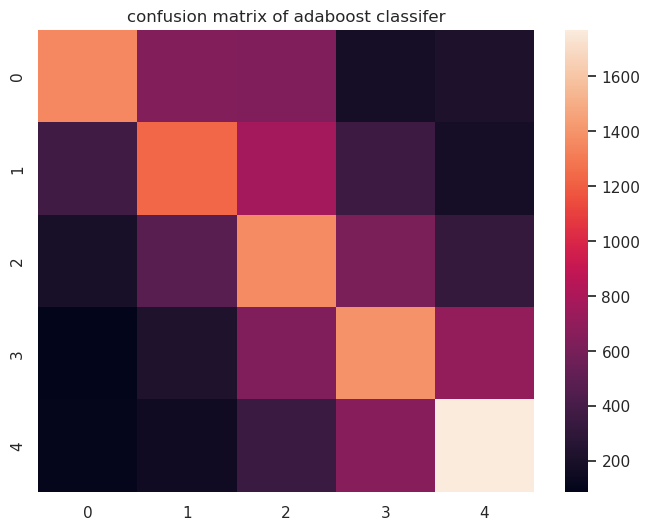

In [19]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
conf = metrics.confusion_matrix(test_labels, test_predictions)
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(conf)
plt.title('confusion matrix of adaboost classifer')

In [20]:
# for i in test_predictions:
#   print(i+1)

In [21]:
# plt.plot(range(num_epochs), train_acc)
# plt.show()

In [22]:
# save this goated model
# torch.save(model, './goodModel.pt')

In [23]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def eval(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  cm = confusion_matrix(y_true, y_pred)

  print("Accuracy: {:.2f}".format(accuracy))
  print("Precision: {:.2f}".format(precision))
  print("Recall: {:.2f}".format(recall))
  print("F1 Score: {:.2f}".format(f1))

  plt.figure(figsize=(4, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, linewidths=0.01, linecolor="gray")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

Accuracy: 0.47
Precision: 0.49
Recall: 0.47
F1 Score: 0.48


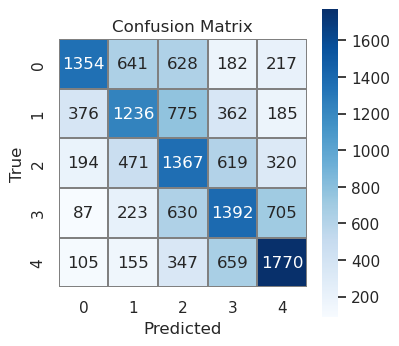

In [24]:
eval(test_labels, test_predictions)

**Dataset Shift**

In [26]:
df = pd.read_csv('Reviews.csv')
# print(df.shape)
df = df
# print(df.shape)

df.head()

# print(df['HelpfulnessNumerator'].unique())
# print(df['HelpfulnessNumerator'].unique().shape)

shift_df_train = df[df['HelpfulnessNumerator'] == 0]
shift_df_test = df[df['HelpfulnessNumerator'] != 0]

shift_df_train['tokenized_text'] = shift_df_train['Text'].apply(word_tokenize)
shift_df_train['filtered_text'] = shift_df_train['tokenized_text'].apply(filter_words)
shift_all_reviews = shift_df_train['filtered_text'].tolist()
shift_df_test['tokenized_text'] = shift_df_test['Text'].apply(word_tokenize)
shift_df_test['filtered_text'] = shift_df_test['tokenized_text'].apply(filter_words)
shift_all_reviews_test = shift_df_test['filtered_text'].tolist()

/tmp/ipykernel_32748/922008194.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df_train['tokenized_text'] = shift_df_train['Text'].apply(word_tokenize)
/tmp/ipykernel_32748/922008194.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df_train['filtered_text'] = shift_df_train['tokenized_text'].apply(filter_words)
/tmp/ipykernel_32748/922008194.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

for loops start
finished first for loops


In [31]:
print('for loops start')

# transform reviews into lists of numbers
e_rev = []
for review in shift_all_reviews:
  e = []
  for word in review:
    if word not in vocab_to_int.keys():
      e.append(0)
    else:
      e.append(vocab_to_int[word])
  e_rev.append(e)

# transform reviews into lists of numbers
e_rev_test = []
for review in shift_all_reviews_test:
  e = []
  for word in review:
    if word not in vocab_to_int.keys():
      e.append(0)
    else:
      e.append(vocab_to_int[word])
  e_rev_test.append(e)

print('finished first for loops')

length = 300
shift_feats = np.zeros((len(e_rev), length), dtype=int)
shift_feats_test = np.zeros((len(e_rev_test), length), dtype=int)

for i, rev in enumerate(e_rev):
  if len(rev) > length:
    shift_feats[i,:] = np.array(rev[:length])
  else:
    for j in range(len(rev)):
      shift_feats[i,j] = rev[j]

for i, rev in enumerate(e_rev_test):
  if len(rev) > length:
    shift_feats_test[i,:] = np.array(rev[:length])
  else:
    for j in range(len(rev)):
      shift_feats_test[i,j] = rev[j]
    
print('finished second for loops')

shift_labels = shift_df_train['Score'].array
shift_labels_test = shift_df_test['Score'].array

for loops start
finished first for loops
finished second for loops


In [32]:
# correct for variable names and run for each dataset (helpful 0 vs nonzero)

data = np.column_stack((shift_feats, shift_labels))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])

data = transform(data)
data = torch.squeeze(data, dim=0)

feats0 = data[:, :-1]
labels = data[:, -1]
labels = F.one_hot(labels.to(torch.int64), num_classes = 6)

labels0 = labels[:, 1:]

# correct for variable names and run for each dataset (helpful 0 vs nonzero)

data = np.column_stack((shift_feats_test, shift_labels_test))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])

data = transform(data)
data = torch.squeeze(data, dim=0)

feats1 = data[:, :-1]
labels = data[:, -1]
labels = F.one_hot(labels.to(torch.int64), num_classes = 6)

labels1 = labels[:, 1:]

In [33]:
# Dataset

test_dataset_0 = TensorDataset(torch.LongTensor(feats0.numpy()), torch.LongTensor(labels0.numpy()))
test_dataset_1 = TensorDataset(torch.LongTensor(feats1.numpy()), torch.LongTensor(labels1.numpy()))

batch_size = 12

test_dataloader_0 = DataLoader(test_dataset_0, batch_size=batch_size, shuffle=False)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)

In [34]:
from logging import exception
model = torch.load('./CNN_accurate.pt')
model.eval()

inputs = shift_feats
labels = shift_labels

test_predictions = np.array([])
test_labels = np.array([])
correct, total = 0, 0 

for i, data in enumerate(test_dataloader_0, 0):

    inputs, labels = data

    # STUDENT TODO START:
    # 1. Store the inputs in the GPU
    inputs = inputs.to(device)
    
    # 2. Get the model predictions
    predictions = model(inputs)
    # STUDENT TODO END

    predicted = torch.max(predictions, 1).indices

    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))
    total += labels.size(0)
    correct += (torch.max(predictions, dim=1).indices.cuda() == torch.max(labels,dim=1).indices.cuda()).sum().item()
    acc = correct/total

Accuracy: 0.54
Precision: 0.69
Recall: 0.54
F1 Score: 0.58


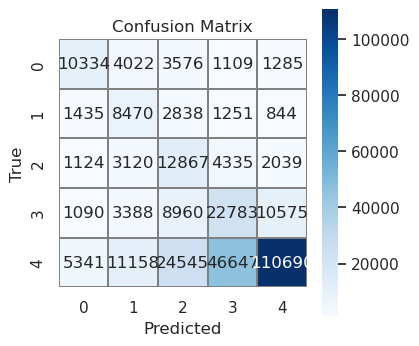

In [35]:
eval(test_labels, test_predictions)

In [36]:
from logging import exception
model = torch.load('./CNN_accurate.pt')
model.eval()

inputs = shift_feats
labels = shift_labels

test_predictions = np.array([])
test_labels = np.array([])
correct, total = 0, 0 

for i, data in enumerate(test_dataloader_1, 0):

    inputs, labels = data

    # STUDENT TODO START:
    # 1. Store the inputs in the GPU
    inputs = inputs.to(device)
    
    # 2. Get the model predictions
    predictions = model(inputs)
    # STUDENT TODO END

    predicted = torch.max(predictions, 1).indices

    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))
    total += labels.size(0)
    correct += (torch.max(predictions, dim=1).indices.cuda() == torch.max(labels,dim=1).indices.cuda()).sum().item()
    acc = correct/total

Accuracy: 0.51
Precision: 0.69
Recall: 0.51
F1 Score: 0.56


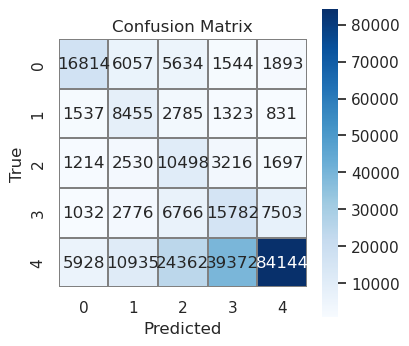

In [37]:
eval(test_labels, test_predictions)